In [22]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
%matplotlib inline

## Gather Data

In [1]:

# Loading listing and review data from Boston
lis_bos = pd.read_csv('dat/boston/listings.csv')
rev_bos = pd.read_csv('dat/boston/reviews.csv')

## Assess

In [10]:
lis_bos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [3]:
lis_bos.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3.585000e+03,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3571.000000,...,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,0.0,0.0,3585.000000,2829.000000
mean,8.440875e+06,2.016091e+13,2.492311e+07,58.902371,58.902371,NaN,42.340032,-71.084818,3.041283,1.221647,...,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,NaN,12.733891,1.970908
std,4.500787e+06,0.000000e+00,2.292781e+07,171.119663,171.119663,NaN,0.024403,0.031565,1.778929,0.501487,...,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,NaN,NaN,29.415076,2.120561
min,3.353000e+03,2.016091e+13,4.240000e+03,0.000000,0.000000,NaN,42.235942,-71.171789,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,4.679319e+06,2.016091e+13,6.103425e+06,1.000000,1.000000,NaN,42.329995,-71.105083,2.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,0.480000
50%,8.577620e+06,2.016091e+13,1.928100e+07,2.000000,2.000000,NaN,42.345201,-71.078429,2.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,NaN,2.000000,1.170000
75%,1.278953e+07,2.016091e+13,3.622147e+07,7.000000,7.000000,NaN,42.354685,-71.062155,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,6.000000,2.720000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,NaN,42.389982,-71.000100,16.000000,6.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


In [4]:
rev_bos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
listing_id       68275 non-null int64
id               68275 non-null int64
date             68275 non-null object
reviewer_id      68275 non-null int64
reviewer_name    68275 non-null object
comments         68223 non-null object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


## Clean
- Remove urls as the url's directs to the home page wich is not very useful.
- Removing all columns with more than 50% missing values
- Remove text columns as they describe the home or surrounding.
- Remove the $ ,% and , signs in columns containing it and convert them to float to ease analysis.
- Since there are few values missing,replace categorical missing values with their mode and continuous values with their mean

In [6]:
def clean_data(df):
    """
    INPUT:
    df - pandas dataframe containing listings informations in Boston
    
    OUTPUT:
    df_final - a new dataframe that has the following characteristics:
    - Remove urls as the url's directs to the home page wich is not very useful.
    - Removing all columns with more than 50% missing values
    - Remove text columns as they describe the home or surrounding.
    - Remove the $ ,% and , signs in columns containing it and convert them to float to ease analysis.
    - Since there are few values missing,replace categorical missing values with their mode and continuous values with their mean
    """
    
    
    df= df.drop(['listing_url','scrape_id','last_scraped','thumbnail_url','medium_url','picture_url','xl_picture_url',
                 'host_url','host_thumbnail_url','host_picture_url','weekly_price','monthly_price',
                 'neighbourhood_group_cleansed','square_feet','has_availability','license','jurisdiction_names','first_review',
                 'last_review','market','neighbourhood', 'host_neighbourhood', 'host_about', 
                 'house_rules', 'interaction','access',
             'transit','notes', 'neighborhood_overview', 'space', 'summary','description','experiences_offered'], axis=1)
   

    # Roving characters in in prices, cleaning fee and security deposit
    df['cleaning_fee'],df['security_deposit'],df['price']=df.cleaning_fee.str.replace('$','').astype(float),df.security_deposit.str.replace('$',''),df.price.str.replace('$','')
    df.security_deposit = df.security_deposit.str.replace(',','').astype(float)
    df.price = df.price.str.replace(',','').astype(float)

    
    #Select the categorical columns 
    df_cat = df.select_dtypes(include=['object'])
    
    
    fill_mode = ['zipcode', 'city', 'host_response_time', 'host_location','property_type']
    # fill columns corresponding to fill_mode with their mode values
    for fill in fill_mode:
        df_cat[fill].fillna(df_cat[fill].mode()[0], inplace=True)
        
   
      #removing % and converting to float in a few columns  
    df_cat.host_acceptance_rate = df_cat.host_acceptance_rate.str.replace('%','').astype(float)
    df_cat.host_response_rate = df_cat.host_response_rate.str.replace('%','').astype(float)
    
     # filling some columns with their mean   
    df_cat['host_acceptance_rate'].fillna(df_cat['host_acceptance_rate'].mean(), inplace=True) 
    df_cat['host_response_rate'].fillna(df_cat['host_response_rate'].mean(), inplace=True) 
    
    # Select float and int datatypes in df
    df_con = df.select_dtypes(include=['int64', 'float64'])
    
    li= ['reviews_per_month','review_scores_value','review_scores_location','review_scores_communication','review_scores_checkin',
    'review_scores_cleanliness','review_scores_accuracy','review_scores_rating','beds','bedrooms','bathrooms','cleaning_fee', 'security_deposit']
    
    # filling missing columns with their mean
    for i in li:
        df_con[i].fillna(df_con[i].mean(), inplace=True)
    df_final= pd.concat([df_cat, df_con], axis =1)
    return df_final
    

In [7]:
df = clean_data(lis_bos)

c:\users\boss\anaconda3\anaconda\envs\kaggle1\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
c:\users\boss\anaconda3\anaconda\envs\kaggle1\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Analyze

In [25]:
def preprocess(df):
    """
     INPUT:
     df - pandas dataframe containing cleaned listings informations in Boston
     
     OUTPUT:
     X_train, X_test, y_train, y_test -  that has the following characteristics:
     
     - Normalized the continuous columns
     - Converting the object data type columns to category for use in Lightgbm
     - Splitting the data into data and label
     - Splitting the data into the training and testing dataset
    """
    # selecting int and float columns in df
    con = df.select_dtypes(['int64', 'float64']).copy()
    #Drop the label column(price)
    con=con.drop('price', axis=1)
    # Normalize the int and float columns in df
    con1 = preprocessing.StandardScaler().fit_transform(con)
    fr =  pd.DataFrame(con1,columns = con.columns)
    # Select the object tye columns in df
    cat = df.select_dtypes(['object']).copy()
    # concatenete both the categorical and continuous columns
    df1 = pd.concat([fr,cat], axis=1)
    
    X = df1
    
    # Normalizing the label y
    y = (df['price'].values- df['price'].min())/(df['price'].max() - df['price'].min()) 
    
    # Converting the object data type columns to category for use in Lightgbm
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')
    # Splitting the data into the training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=314)
    
    return X_train, X_test, y_train, y_test,X,y

In [26]:
X_train, X_test, y_train, y_test ,X, y= preprocess(df)

## Model

In [16]:
fit_params={
    "early_stopping_rounds":10, 
            "eval_metric" : 'mae', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

In [17]:

# instantiate model
clf = lgb.LGBMRegressor(num_leaves= 10, max_depth=5, 
                         random_state=314,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=1000,
                         
                         learning_rate=0.01)

# Traning the model
clf.fit(X_train, y_train, **fit_params)



Training until validation scores don't improve for 10 rounds.
[100]	valid's l1: 0.014795
[200]	valid's l1: 0.0129716
[300]	valid's l1: 0.0123299
[400]	valid's l1: 0.0119844
[500]	valid's l1: 0.0117868
[600]	valid's l1: 0.0116787
Early stopping, best iteration is:
[659]	valid's l1: 0.0116179


LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.9, learning_rate=0.01,
       max_bin=255, max_depth=5, metric='None', min_child_samples=10,
       min_child_weight=5, min_split_gain=0.0, n_estimators=1000, n_jobs=4,
       num_leaves=10, objective=None, random_state=314, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.9, subsample_for_bin=50000,
       subsample_freq=1)

In [18]:
# predicting X_test
y_pred = clf.predict(X_test)

In [20]:
#Accuracy
mean_absolute_error =mean_absolute_error(y_pred,y_test)

In [21]:
# overall mean_absolute_error 
mean_absolute_error

0.011611463300111992

## Visualize

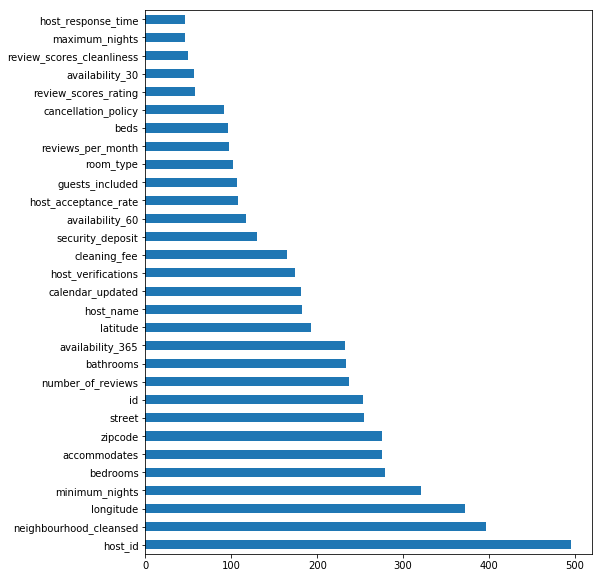

In [27]:
# Plotting features by importance
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

### We need to modify the class so that it outputs feature importance according to which one is relevant to predicting price 

In [28]:

class LGBMRegressor_GainFE(lgb.LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')
    

In [29]:
clf2 = LGBMRegressor_GainFE(num_leaves= 15, max_depth=10, 
                         random_state=314, 
                         silent=True, 
                         metric='mae', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)

In [30]:
clf2.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 10 rounds.
[100]	valid's l1: 0.0144867
[200]	valid's l1: 0.0127126
[300]	valid's l1: 0.0119751
[400]	valid's l1: 0.0116183
[500]	valid's l1: 0.0114092
Early stopping, best iteration is:
[527]	valid's l1: 0.0113808


LGBMRegressor_GainFE(boosting_type='gbdt', colsample_bytree=0.9,
           learning_rate=0.01, max_bin=255, max_depth=10, metric='mae',
           min_child_samples=10, min_child_weight=5, min_split_gain=0.0,
           n_estimators=1000, n_jobs=4, num_leaves=15, objective=None,
           random_state=314, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=0.9, subsample_for_bin=50000, subsample_freq=1)

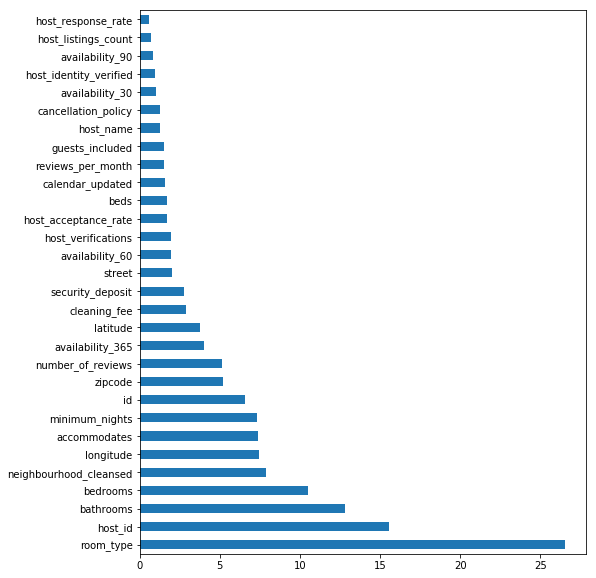

In [31]:
feat_imp = pd.Series(clf2.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))